# Proyecto práctico

## Unidad 3 - Aprendizaje supervisado

El proyecto práctico consiste en abordar un problema de clasificación de documentos textuales. Tenemos a nuestra disposición un dataset de noticias de prensa en español publicada por el medio "CNN Chile".

Las noticias están divididas en 7 categorías temáticas: *'pais','deportes','tendencias','tecnologias','cultura','economia','mundo'*

El proyecto se divide en dos partes:

- Utilizar al menos 3 estrategías para entrenar modelos de clasificación capaces de clasificar las noticias según su categoría temática.

- Explorar cuáles son las características que permiten explicar las decisiones de su modelo.

## 0. Evaluación

El proyecto se realiza de forma individual. Se entrega a más tardar el **lunes 30 de noviembre** en su repositorio GitHub.

**Pauta de evaluación:**

Competencia 1: Aplicar un protocolo de aprendizaje supervisado para resolver un problema clasificación estandar, utilizando un entorno de programación en Python

- < 2 : El protocolo de aprendizaje supervisado utilizado es incompleto y/o presenta errores importantes
- 2 a 3.9 : El protocolo de aprendizaje supervisado utilizado es incompleto o presenta un error importante
- 4 a 5.5 : El protocolo de aprendizaje es completo, no tiene error, pero las estrategias utilizadas son relativamente simples y el rendimiento de los modelos es perfectible.
- 5.6 a 7.0 : El protocolo de aprendizaje es completo, no tiene error y al menos una de las estrategias utilizadas a necesitado un trabajado más avanzado y/o permite obtener un mejor rendimiento.

Competencia 2: Explicar el rendimiento de un modelo de clasificación aplicando un protocolo de evaluación Precision/Recall/F-Score

- < 2 : El trabajo no presenta explicaciones del rendimiento de los modelos de clasificación
- 2 a 3.9 : El trabajo presenta algunas explicaciones pero tienen errores.
- 4 a 5.5 : El trabajo presenta explicaciones correctas del rendimiento de los modelos
- 5.6 a 7 : El trabajo presenta explicaciones correctas del rendimiento de los modelos y además presenta un método para explicar las decisiones/errores


## 1. Dataset

In [113]:
import pandas as pd
import seaborn as sb
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

df = pd.read_csv('cnnchile_7000.csv')
df

,country,media_outlet,url,title,text,date,category
0,chile,cnnchile,https://www.cnnchile.com/pais/pdta-del-colegio...,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,2018-03-29 00:00:00.000000,pais
1,chile,cnnchile,https://www.cnnchile.com/pais/defensoria-ninez...,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,2020-08-02 00:00:00.000000,pais
2,chile,cnnchile,https://www.cnnchile.com/pais/cuanto-les-pagar...,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,2016-10-20 00:00:00.000000,pais
3,chile,cnnchile,https://www.cnnchile.com/pais/sobrino-de-aleja...,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,2017-11-13 00:00:00.000000,pais
4,chile,cnnchile,https://www.cnnchile.com/pais/analisis-sobre-e...,Análisis sobre el aumento de impuestos para al...,Especialistas recomiendan no consumir más de 2...,2014-05-05 00:00:00.000000,pais
...,...,...,...,...,...,...,...
6995,chile,cnnchile,https://www.cnnchile.com/tecnologias/playstati...,PlayStation 5 vs Xbox Series X: Mira la compar...,Las compañías ya han revelado muchos detalles ...,2020-09-18 00:00:00.000000,tecnologias
6996,chile,cnnchile,https://www.cnnchile.com/tecnologias/android-l...,Android le dará “una paliza” a Windows en 2013,Se proyecta que tras un virtual empate en 2012...,2013-04-04 00:00:00.000000,tecnologias
6997,chile,cnnchile,https://www.cnnchile.com/tecnologias/regalos-t...,Regalos tecnológicos marcaron pauta en Navidad,Tablets y smartphones fueron los regalos tecno...,2012-12-26 00:00:00.000000,tecnologias
6998,chile,cnnchile,https://www.cnnchile.com/tecnologias/jugar-con...,Jugar con Fox en Starlink vale totalmente la p...,Crecí jugando clásicos de naves como Terminal ...,2018-10-30 00:00:00.000000,tecnologias


In [2]:
from pandasql import sqldf

q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,tendencias,1000
1,tecnologias,1000
2,pais,1000
3,mundo,1000
4,economia,1000
5,deportes,1000
6,cultura,1000


In [110]:
import sys

#!{sys.executable} -m spacy download es

nlp = spacy.load("es")

from sklearn import metrics

## 1.1 Preprocessing

Es necesario quitar las columnas que no dan información relevante para el análisis, como país, medio de comunicación, fecha y url.

In [3]:
data = df.drop(columns=["country", "media_outlet", "url", "date"])

data[:10]

,title,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,pais
1,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,pais
2,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,pais
4,Análisis sobre el aumento de impuestos para al...,Especialistas recomiendan no consumir más de 2...,pais
5,Encuesta Libertad y Desarrollo: Temor a perder...,Francisco Klapp profundizó en el último sondeo...,pais
6,Presidenta decretó zona de catástrofe para reg...,La mandataria informó que recibió mensajes de ...,pais
7,Autoridades de Transporte anunciaron nuevos bu...,El Ministro de Transporte Andrés Gómez-Lobo en...,pais
8,Polémica por cantidad de casas destruidas,Confución generaron los datos entregados por l...,pais
9,Interponen nueva demanda contra CCU por prácti...,La firma ligada al grupo Luksic habría iniciad...,pais


In [4]:
data.isnull().sum()

title       1
text        0
category    0
dtype: int64

Existe 1 campo sin título, por efectos de simplicidad lo eliminaremos

In [5]:
data.dropna(inplace=True)
data.isnull().sum()

title       0
text        0
category    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6999 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6999 non-null   object
 1   text      6999 non-null   object
 2   category  6999 non-null   object
dtypes: object(3)
memory usage: 218.7+ KB


In [83]:
data_final = data.copy()

titles = []
for title in data_final["title"]:
    titles.append(title)

index = 0
for text in data_final["text"]:
    data_final["text"][index] = titles[index] + ". " + text
    index+=1

data_final = data_final.drop(columns=["title"])

data_final[:5]

,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,pais
1,Defensoría de la Niñez pide al Estado velar po...,pais
2,¿Cuánto les pagarán a los vocales de mesa?. El...,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,pais
4,Análisis sobre el aumento de impuestos para al...,pais


## 1.2 Features

In [108]:
def feature_tokenizer(text):
    tokens = nlp(text)

    #Guardamos las palabras como características si se considera sustantivo, adjetivo o verbo
    tokens = [word for word in tokens if word.pos_ in ["NOUN", "ADJ", "VERB"]]
    
    #Palabras en minusculas
    tokens = [word.lemma_.lower().strip() for word in tokens]

    return tokens

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = feature_tokenizer, min_df=0., max_df=1.0)

> Separamos la información de las etiquetas

In [85]:
X = data_final["text"]
print(X)
Y_label = data_final["category"]
print(Y_label)

0       Pdta. del Colegio de Matronas explicó los ries...
1       Defensoría de la Niñez pide al Estado velar po...
2       ¿Cuánto les pagarán a los vocales de mesa?. El...
3       Sobrino de Alejandro Navarro intenta “funar” e...
4       Análisis sobre el aumento de impuestos para al...
                              ...                        
6995    Android le dará “una paliza” a Windows en 2013...
6996    Regalos tecnológicos marcaron pauta en Navidad...
6997    Jugar con Fox en Starlink vale totalmente la p...
6998    Konami lanza PES 2018 de forma gratuita para i...
6999    Konami Digital Entertainment ha anunciado que ...
Name: text, Length: 6999, dtype: object
0              pais
1              pais
2              pais
3              pais
4              pais
           ...     
6995    tecnologias
6996    tecnologias
6997    tecnologias
6998    tecnologias
6999    tecnologias
Name: category, Length: 6999, dtype: object


> Se codifican las etiquetas para que sean mas fáciles de manejar

In [101]:
from sklearn.preprocessing import LabelEncoder
encoded_Y_labels = LabelEncoder().fit_transform(Y_label)
encoded_Y_labels

array([4, 4, 4, ..., 5, 5, 5])

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y_labels, test_size=0.25)

In [95]:
X_train

2251    Nuevamente hacen historia: La Roja venció a Br...
144     Osvaldo Andrade por Insulza: “Las declaracione...
952     Ex carabinero sospechoso de femicidio es vincu...
5151    “Guardians of the South”, la serie animada sob...
303     Frente Amplio tendría primarias legales. Este ...
                              ...                        
5877    Confirman las fechas y programación de artista...
5928    Slayer, Megadeth y Anthrax encabezarán la cuar...
6176    Uber ocultó “hackeo” masivo. Uber habría sido ...
1298    Embajador de Israel en Chile: “La meta es que ...
1771    Estas ciudades europeas están hartas de los tu...
Name: text, Length: 5249, dtype: object

In [96]:
X_test

549     Ernesto Galaz valoró la condena al Estado por ...
2420    Ciclista Irene Aravena permanece estable tras ...
2880    El ataque de Martín Liberman por la sanción de...
1860    Trump no descartó firmar nueva orden ejecutiva...
3981    Astronauta graba videoclip en el espacio. El c...
                              ...                        
2934    La “U” es el líder del Torneo de Clausura lueg...
6773    Conoce la aplicación chilena HappyShop.  Happy...
5472    “Nunca subí el Provincia”, el documental chile...
6505    Los videos y tendencias más importantes de la ...
3676    Esta es la razón por la que no deberías lanzar...
Name: text, Length: 1750, dtype: object

In [97]:
y_train

array([1, 4, 4, ..., 5, 3, 3])

In [98]:
y_test

array([4, 1, 1, ..., 0, 5, 6])

## 2.1 Regresión Logística

In [109]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()

pipe = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', logistic_regression_model)])

pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B903B1ED30>)),
                ('learning', LogisticRegression())])

In [112]:
predicted = pipe.predict(X_test)

print(predicted)

predicted_proba = pipe.predict_proba(X_test)

print(predicted_proba)

[4 1 1 ... 0 5 6]
[[0.10980922 0.09525912 0.06180998 ... 0.39777432 0.02897751 0.05719594]
 [0.03650962 0.29233592 0.06432344 ... 0.14538252 0.08276289 0.17358975]
 [0.06311962 0.70809694 0.0156034  ... 0.02876887 0.05452071 0.07037024]
 ...
 [0.7824633  0.01866134 0.01599551 ... 0.03059838 0.0516338  0.07915476]
 [0.01104179 0.12759142 0.20781625 ... 0.12132472 0.37299436 0.05098382]
 [0.06817454 0.03813424 0.05423387 ... 0.06461888 0.24642136 0.30183623]]


In [115]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.788


In [116]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, predicted)
print(confusion_matrix)

from sklearn.metrics import classification_report

print(classification_report(y_test, predicted))

[[219   1   0   1   5   0   9]
 [  0 223   5   3  10   1  16]
 [  0   0 214   4  24   8   6]
 [  4   9  16 184  23   4  18]
 [  2   4  18  24 189   6  10]
 [  5   1   9   4  11 177  30]
 [ 22   8   7   7   7  29 173]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       235
           1       0.91      0.86      0.88       258
           2       0.80      0.84      0.82       256
           3       0.81      0.71      0.76       258
           4       0.70      0.75      0.72       253
           5       0.79      0.75      0.77       237
           6       0.66      0.68      0.67       253

    accuracy                           0.79      1750
   macro avg       0.79      0.79      0.79      1750
weighted avg       0.79      0.79      0.79      1750



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

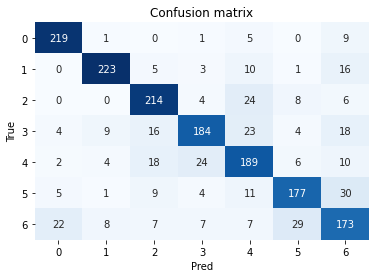

In [114]:
classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sb.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

## 2.2 Naïve Bayes

In [117]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

model_nb = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', nb)])

In [118]:
model_nb.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B903B1ED30>)),
                ('learning', MultinomialNB())])

In [119]:
predicted = model_nb.predict(X_test)

In [121]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.7605714285714286


In [120]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

print(confusion_matrix)

print(classification_report(y_test, predicted))

[[227   0   1   3   2   0   2]
 [ 11 220   8   3   8   4   4]
 [  2   0 225   3  18   8   0]
 [ 15   6  23 180  20   9   5]
 [  5   1  30  24 181   9   3]
 [ 13   1  12   5   8 185  13]
 [ 57   7  10   7   8  51 113]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.80       235
           1       0.94      0.85      0.89       258
           2       0.73      0.88      0.80       256
           3       0.80      0.70      0.75       258
           4       0.74      0.72      0.73       253
           5       0.70      0.78      0.74       237
           6       0.81      0.45      0.58       253

    accuracy                           0.76      1750
   macro avg       0.77      0.76      0.75      1750
weighted avg       0.77      0.76      0.75      1750



## 2.3 Arbol de decisión

In [124]:
from sklearn import tree

my_tree = tree.DecisionTreeClassifier()

model_tree = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', my_tree)])

In [125]:
model_tree.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B903B1ED30>)),
                ('learning', DecisionTreeClassifier())])

In [126]:
predicted = model_tree.predict(X_test)

In [128]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.5337142857142857


In [127]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

print(confusion_matrix)

print(classification_report(y_test, predicted))

[[173  11   3   7  12  10  19]
 [  4 170  10  14  23  12  25]
 [  8   6 133  26  49  25   9]
 [ 11  15  27 127  43  14  21]
 [ 11  14  25  51 115  19  18]
 [ 19  15  23  11  17 115  37]
 [ 39  20  15  24  18  36 101]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       235
           1       0.68      0.66      0.67       258
           2       0.56      0.52      0.54       256
           3       0.49      0.49      0.49       258
           4       0.42      0.45      0.43       253
           5       0.50      0.49      0.49       237
           6       0.44      0.40      0.42       253

    accuracy                           0.53      1750
   macro avg       0.53      0.54      0.53      1750
weighted avg       0.53      0.53      0.53      1750



In [130]:
txt_representation = tree.export_text(my_tree, feature_names=tfidf_vectorizer.get_feature_names(), max_depth=10)
print(txt_representation)

|--- artista <= 0.01
|   |--- jugador <= 0.04
|   |   |--- económico <= 0.05
|   |   |   |--- película <= 0.03
|   |   |   |   |--- tecnología <= 0.03
|   |   |   |   |   |--- presidente <= 0.02
|   |   |   |   |   |   |--- gol <= 0.03
|   |   |   |   |   |   |   |--- video <= 0.06
|   |   |   |   |   |   |   |   |--- usuario <= 0.04
|   |   |   |   |   |   |   |   |   |--- banda <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- alzar <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 108
|   |   |   |   |   |   |   |   |   |   |--- alzar >  0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- banda >  0.01
|   |   |   |   |   |   |   |   |   |   |--- realizar <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- realizar >  0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|